In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("data/TRACT_ZIP_122020.xlsx")

```
ZIP	5 digit USPS ZIP code
TRACT	11 digit unique 2000 or 2010 Census tract GEOID consisting of state FIPS + county FIPS + tract code. The decimal is implied and leading and trailing zeros have been preserved.
COUNTY	5 digit unique 2000 or 2010 Census county GEOID consisting of state FIPS + county FIPS.
CBSA	5 digit CBSA code for Micropolitan and Metropolitan Areas as defined by OMB in February of 2013. ZIP codes with a CBSA code of ‘99999’ are not located within a CBSA. In Metropolitan Areas that are broken out into Divisions, the code reported is the CBSA Metropolitan Division code.
CD	The 5 digit code for Congressional District is a combination of the 2 digit state FIPS code and the Congressional District number.
RES_RATIO	The ratio of residential addresses in the ZIP – Tract, County, or CBSA part to the total number of residential addresses in the entire ZIP.
BUS_RATIO	The ratio of business addresses in the ZIP – Tract, County, or CBSA part to the total number of business addresses in the entire ZIP.
OTH_RATIO	The ratio of other addresses in the ZIP – Tract, County, or CBSA part to the total number of other addresses in the entire ZIP.
TOTAL_RATIO	The ratio of all addresses in the ZIP – Tract, County, or CBSA part to the total number of all types of addresses in the entire ZIP.
USPS_ZIP_PREF_CITY	USPS preferred city name. Note: ZIP code preferred names frequently do not align with administrative/political names. Furthermore, ZIP code boundaries frequently do not align with administrative/political boundaries. For more information, please see USPS City Versus Census Geography.
USPS_ZIP_PREF_STATE	USPS preferred state address state.
```

In [4]:
crosswalk = pd.read_csv("data/fips_crosswalk_merged.csv")

In [6]:
len(crosswalk)

9096

In [7]:
df_ = df.merge(
    crosswalk, 
    left_on='TRACT',
    right_on='FIPS',
    how="inner",
)

In [8]:
len(df_)

12062

In [9]:
df_.head()

TRACT    ZIP  RES_RATIO  BUS_RATIO  OTH_RATIO  TOT_RATIO        FIPS  \
0  6001400100  94720   0.000000   0.958974   0.934783   0.158721  6001400100   
1  6001400100  94704   0.040474   0.000000   0.000000   0.033721  6001400100   
2  6001400100  94563   0.000698   0.000000   0.000000   0.000581  6001400100   
3  6001400100  94618   0.267271   0.025641   0.000000   0.225581  6001400100   
4  6001400100  94611   0.041172   0.000000   0.021739   0.035465  6001400100   

  STATE_ABBR  STATE_FIPS  COUNTY_FIPS  STCOFIPS  TRACT_FIPS  POPULATION_2020  \
0         CA           6            1      6001      400100             3038   
1         CA           6            1      6001      400100             3038   
2         CA           6            1      6001      400100             3038   
3         CA           6            1      6001      400100             3038   
4         CA           6            1      6001      400100             3038   

   POP20_SQMI  SQMI  FIPS.1  
0      1133.6  2.68  1765.0  
1      1133.6  2.68  1765.0  
2      1133.6  2.68  1765.0  
3      1133.6  2.68  1765.0  
4      1133.6  2.68  1765.0

In [10]:
zips = df_.ZIP.astype(str).unique()

In [44]:
# There are 1,763 California zip codes 
# according to Google
len(zips)

2183

In [12]:
import matplotlib.pyplot as plt 

In [13]:
import geopandas as gpd

In [14]:
states = gpd.read_file('data/shapefiles/tl_2020_us_zcta520/tl_2020_us_zcta520.shp')

In [16]:
bad_zips = states.ZCTA5CE20.unique()

In [17]:
len(bad_zips)

33791

In [18]:
bad_zips = set(bad_zips)-set(zips)

In [19]:
for z in bad_zips:
    states = states[states.ZCTA5CE20 != z]

In [20]:
len(states.ZCTA5CE20.unique())

1678

<Axes: >

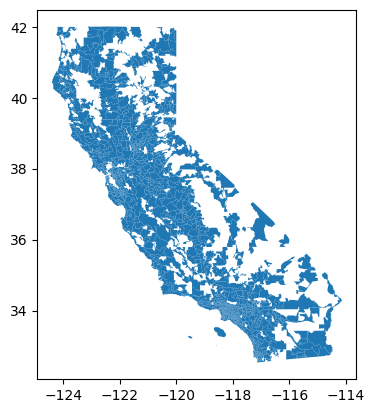

In [21]:
states.plot()

In [39]:
import plotting
%load_ext autoreload
%autoreload 2
hss = plotting.get_hotspopt_dict()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get aggregated hotspots

In [45]:
df = pd.read_parquet("outputs/merged_heatday_coldday_wfday_polluted_smoke_polluted.parquet")

In [46]:
df = df[['wfday','heatday', 'coldday','polluted', 'smoke_polluted']]

In [47]:
df = df.reset_index()

In [48]:
df = df.merge(df_, left_on="FIPS", right_on="FIPS.1")

In [49]:
df = df[['time', 'wfday', 'heatday', 'coldday', 'polluted',
       'smoke_polluted', 'ZIP']]

In [50]:
df = df.groupby(by=['time', 'ZIP']).max()

In [51]:
df['ws'] = df['wfday'] & df['smoke_polluted']

df['hw'] = df['wfday'] & df['heatday']

df['hp'] = df['heatday'] & df['polluted']

df['hwp'] = df['heatday'] & df['wfday'] & df['polluted']

df['hws'] = df['heatday'] & df['wfday'] & df['smoke_polluted']

df['hwps'] = df[['heatday','wfday','polluted','smoke_polluted']].sum(axis=1)

In [52]:
df = df.reset_index().groupby('ZIP').sum()

/var/folders/b_/vlxgm9n10bz569rffzmcc5dc0000gn/T/ipykernel_45757/384323753.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.reset_index().groupby('ZIP').sum()


In [53]:
df = df.reset_index()
df.ZIP = df.ZIP.astype(str)

In [54]:
df = df.merge(states, left_on="ZIP", right_on="ZCTA5CE20")

In [55]:
df = df.set_geometry(df.geometry)

In [56]:
len(df.ZIP.unique())

1667

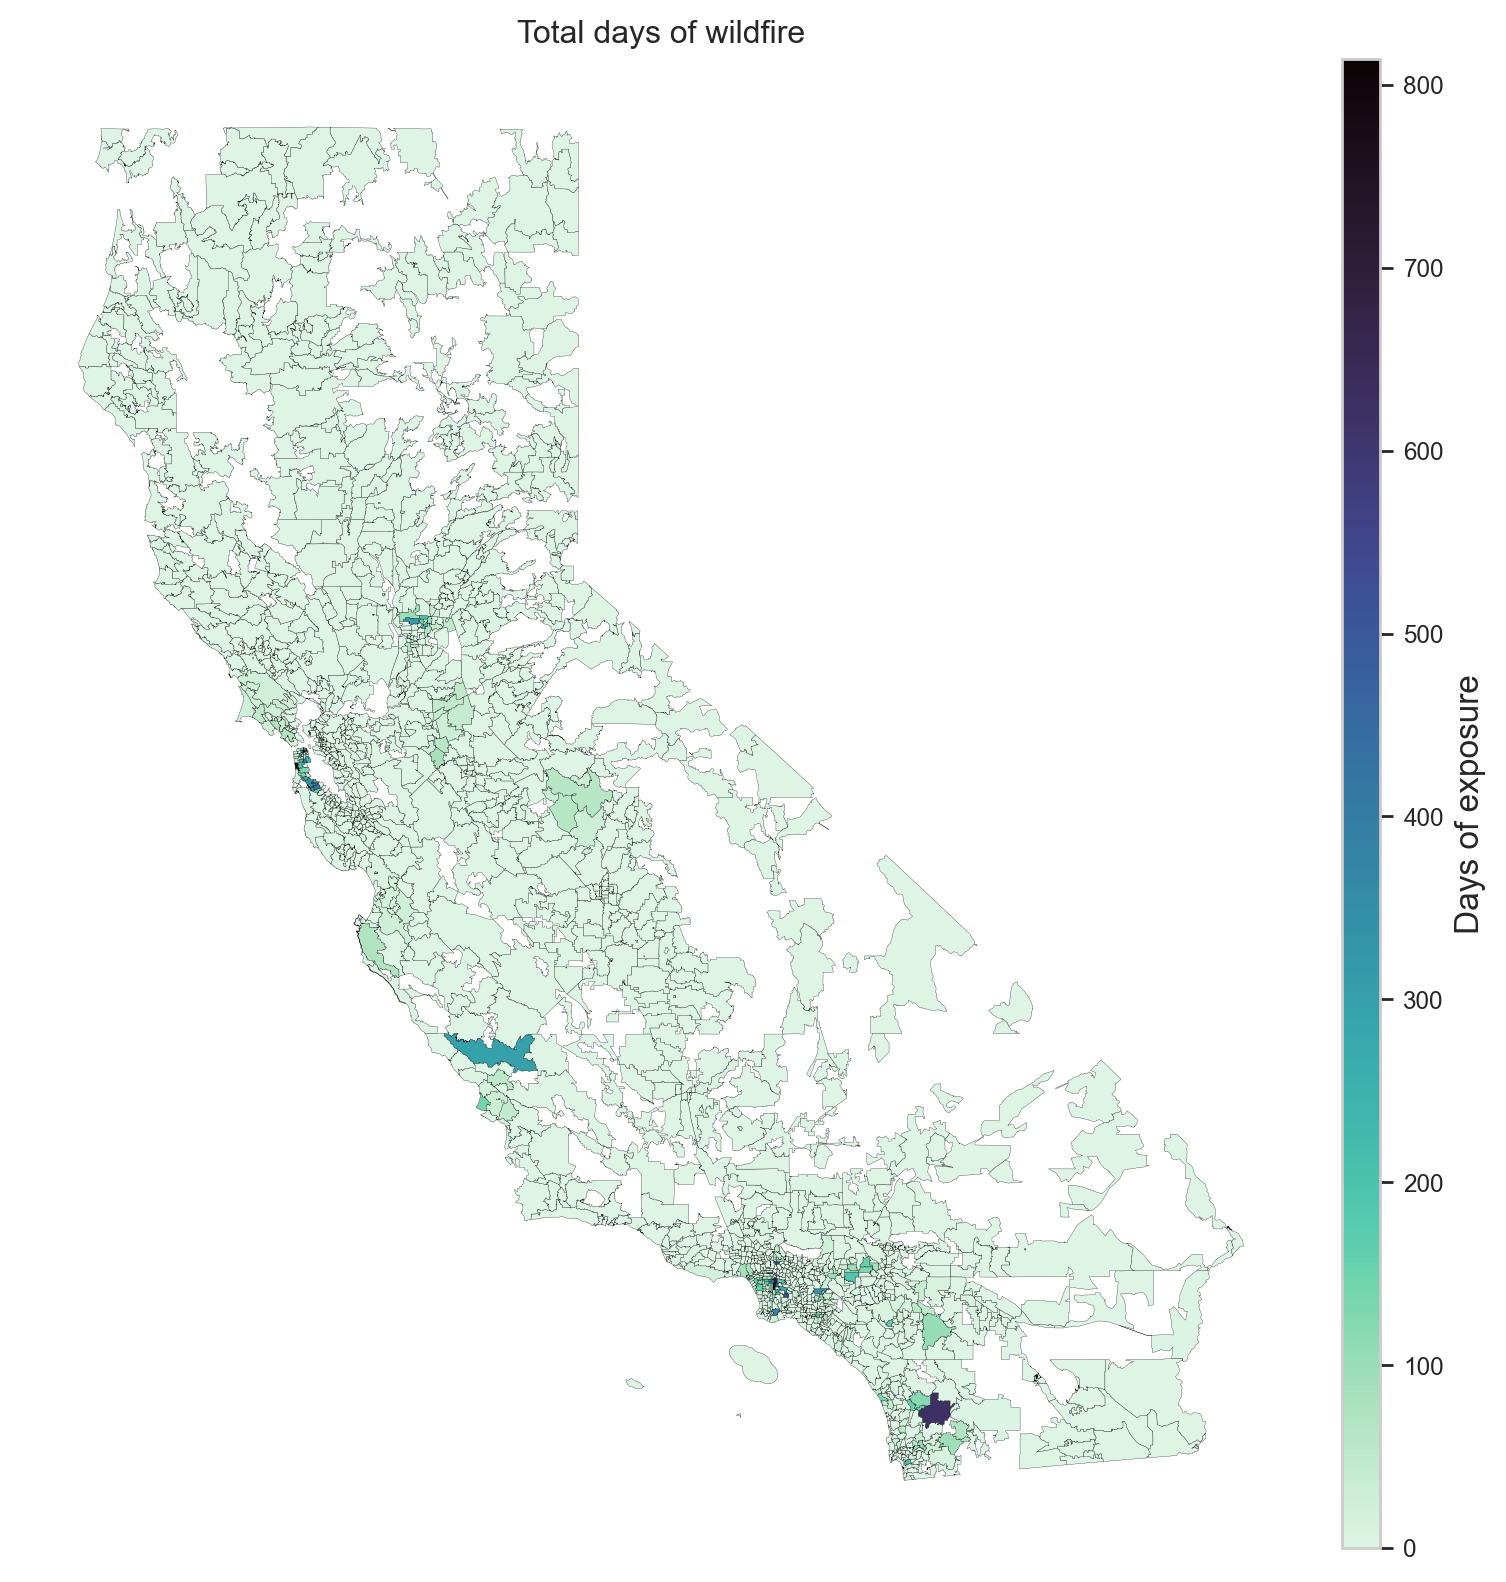

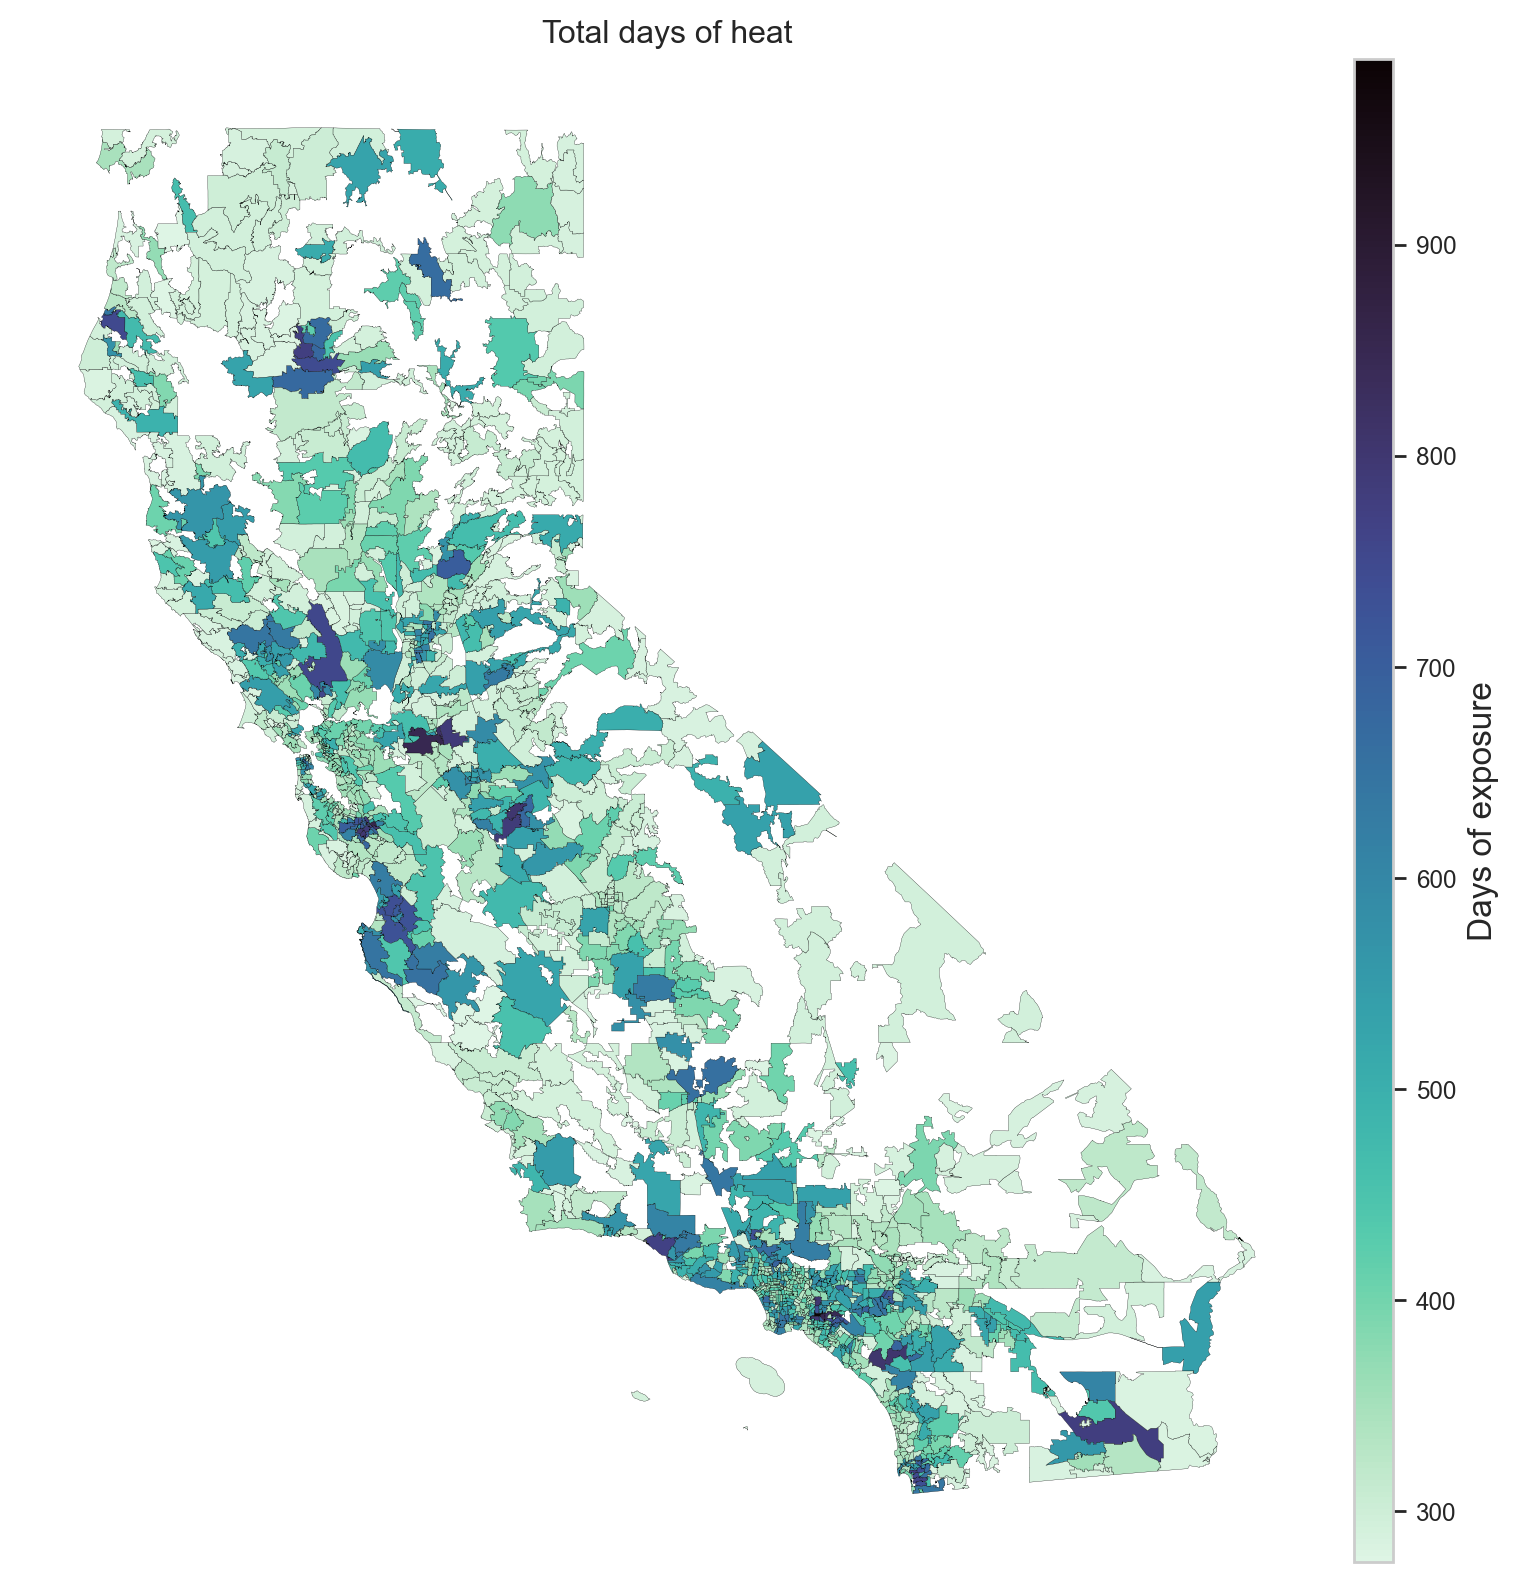

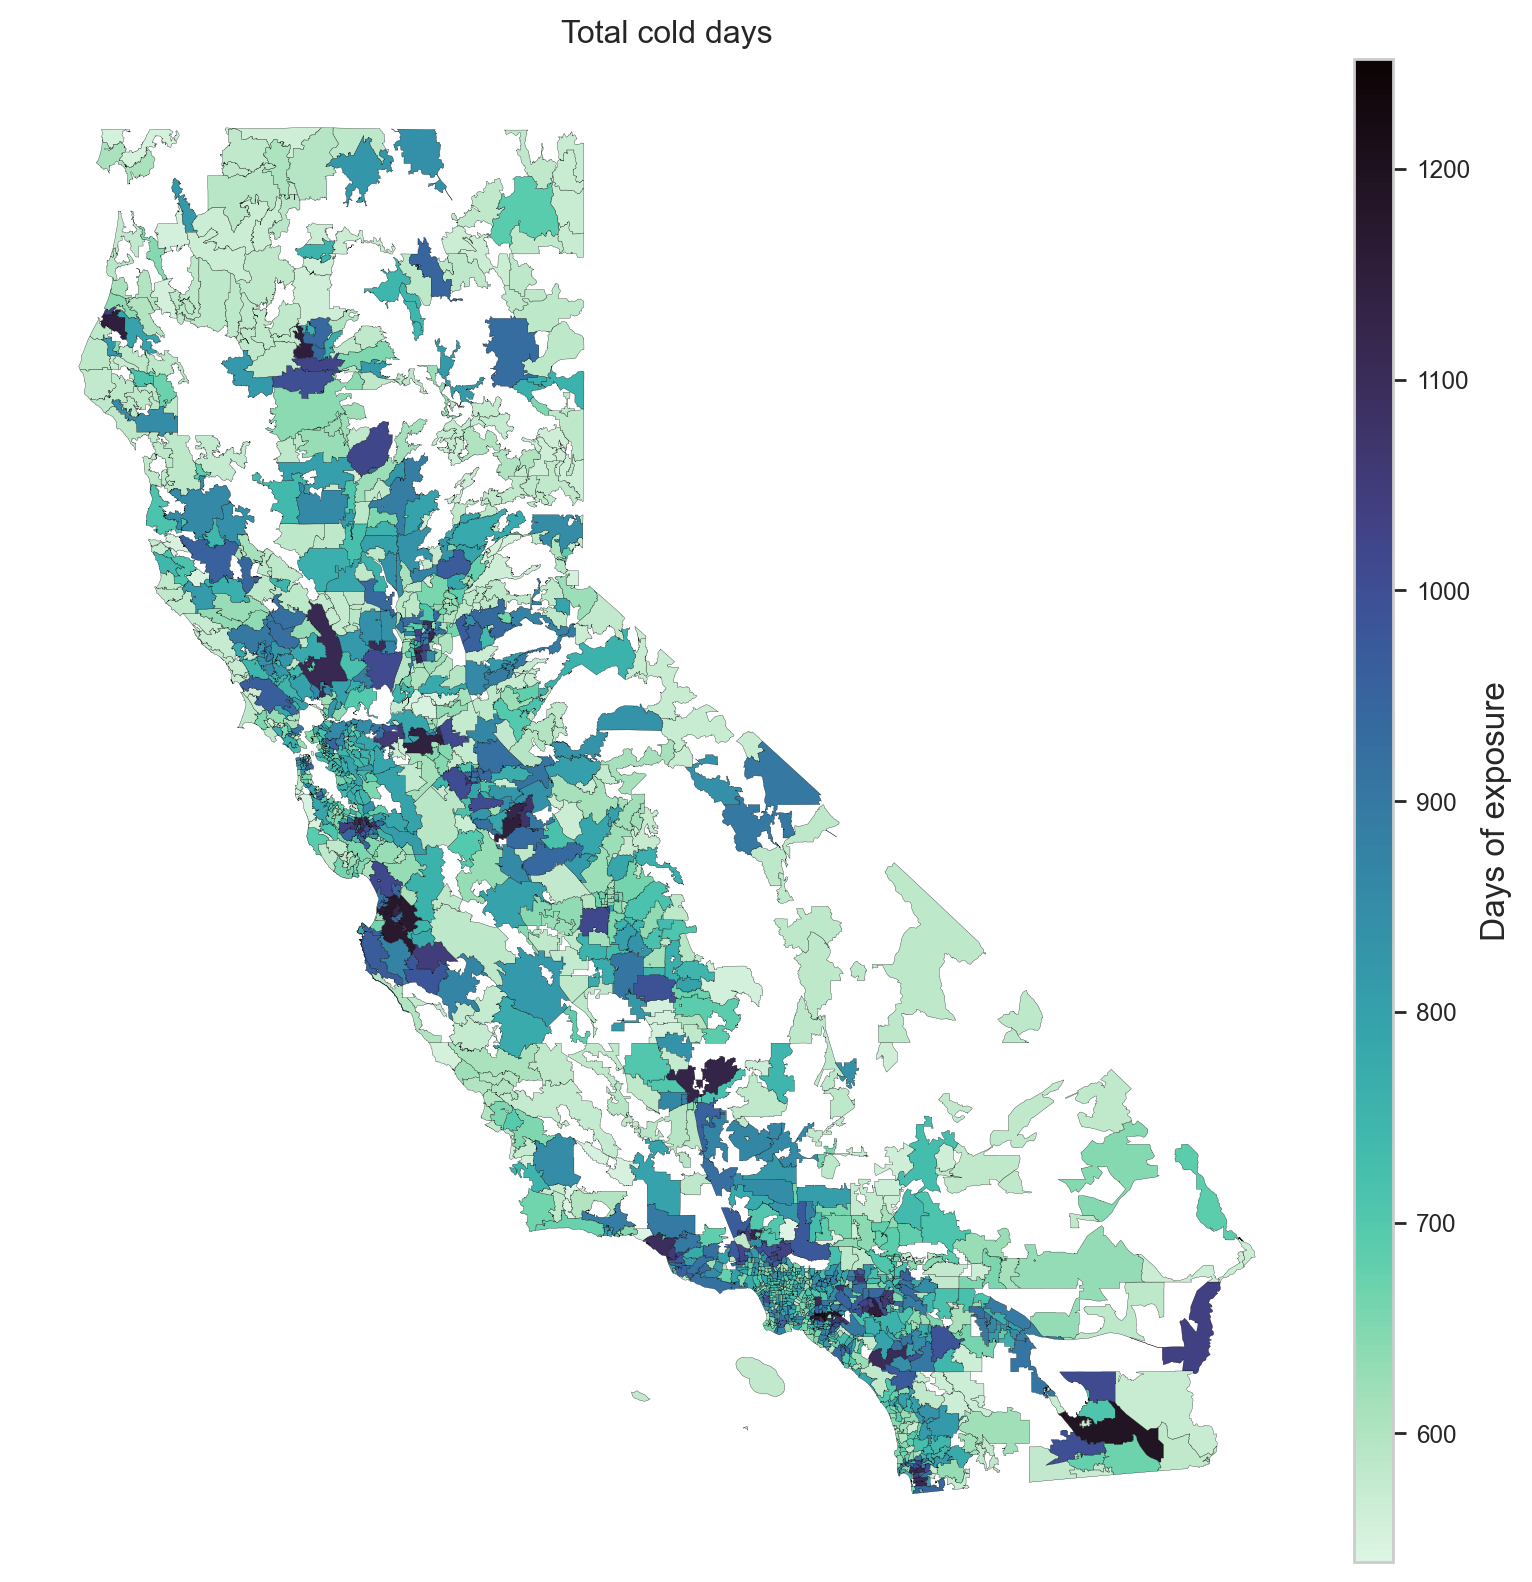

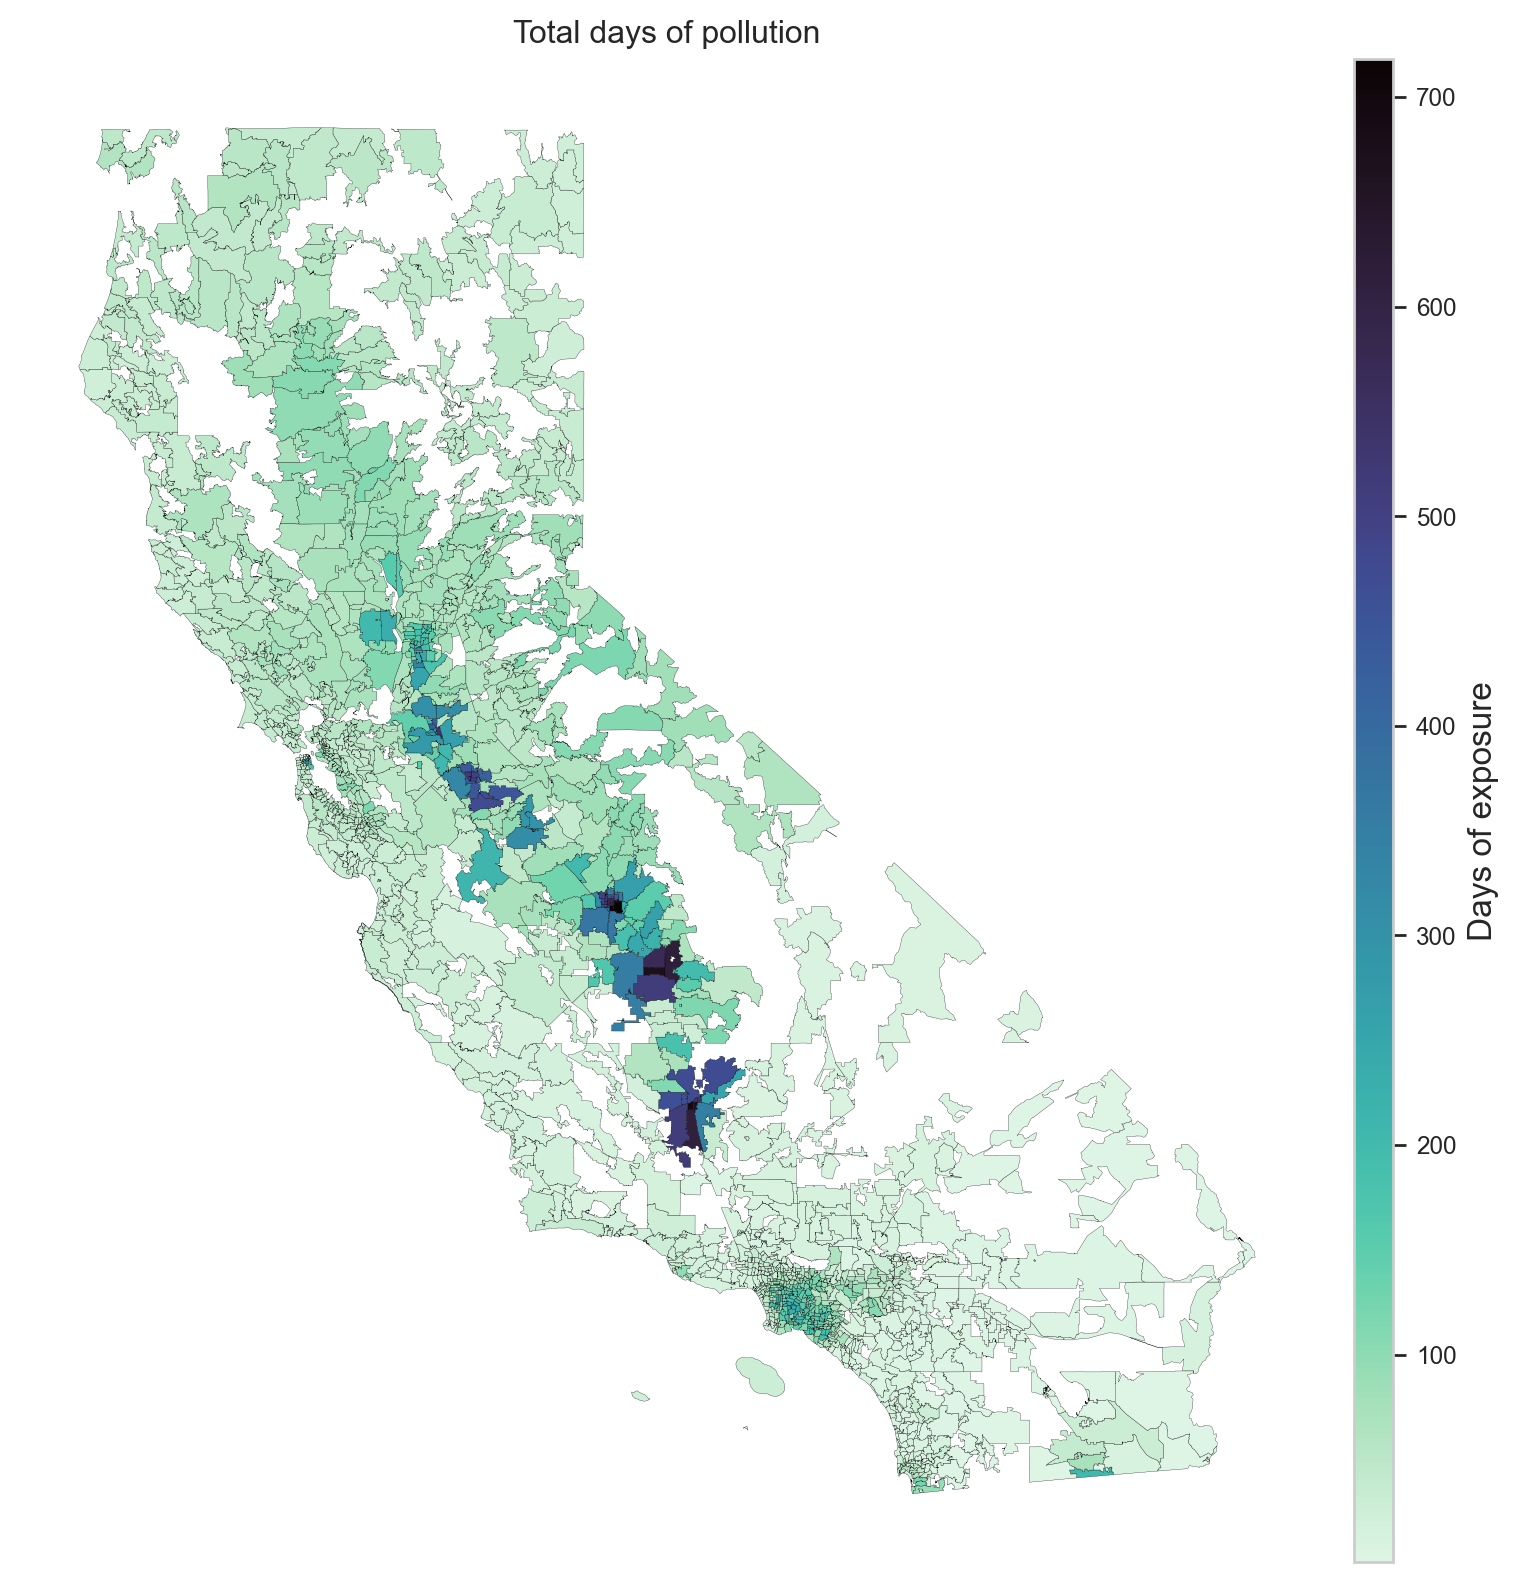

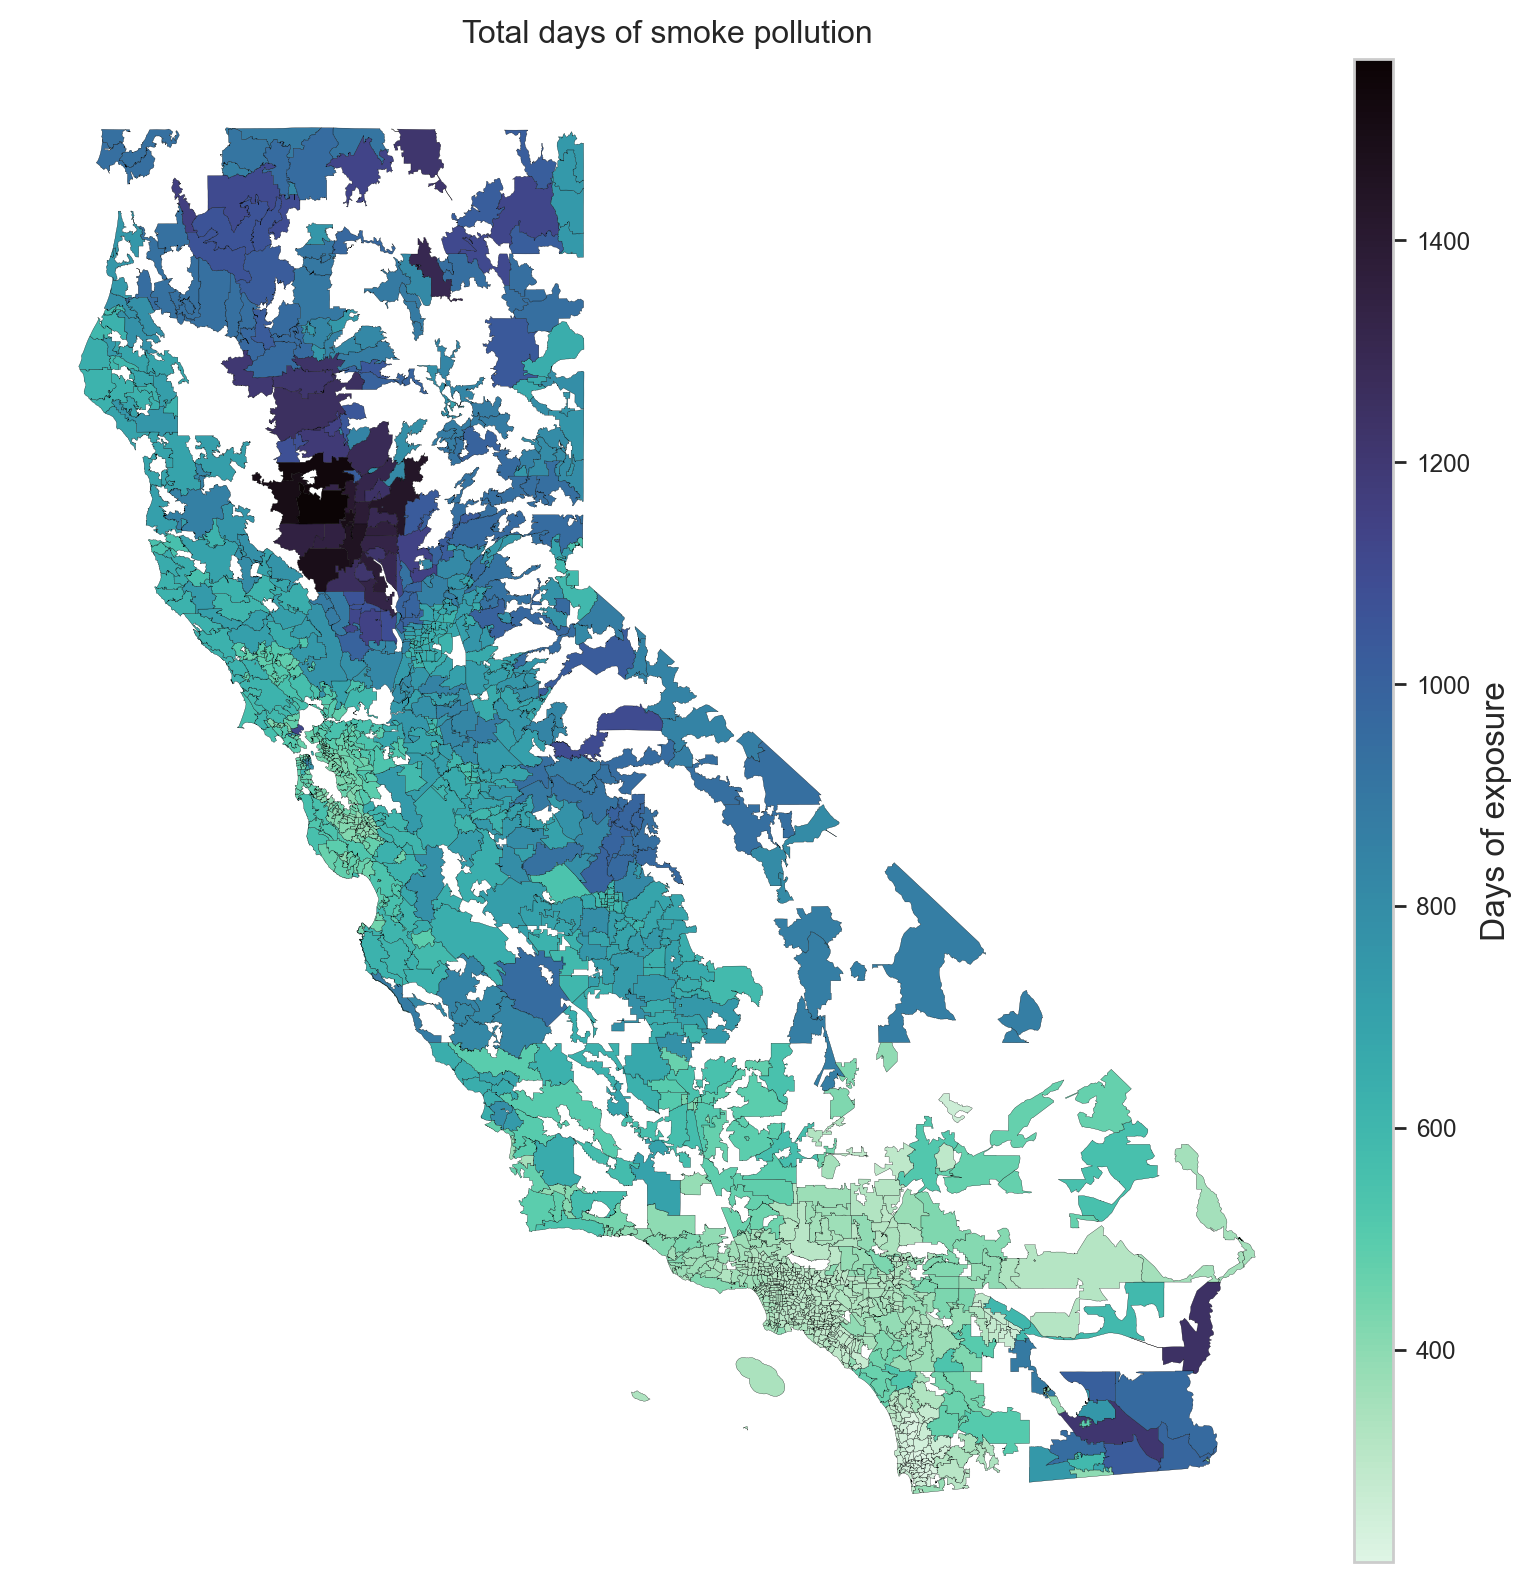

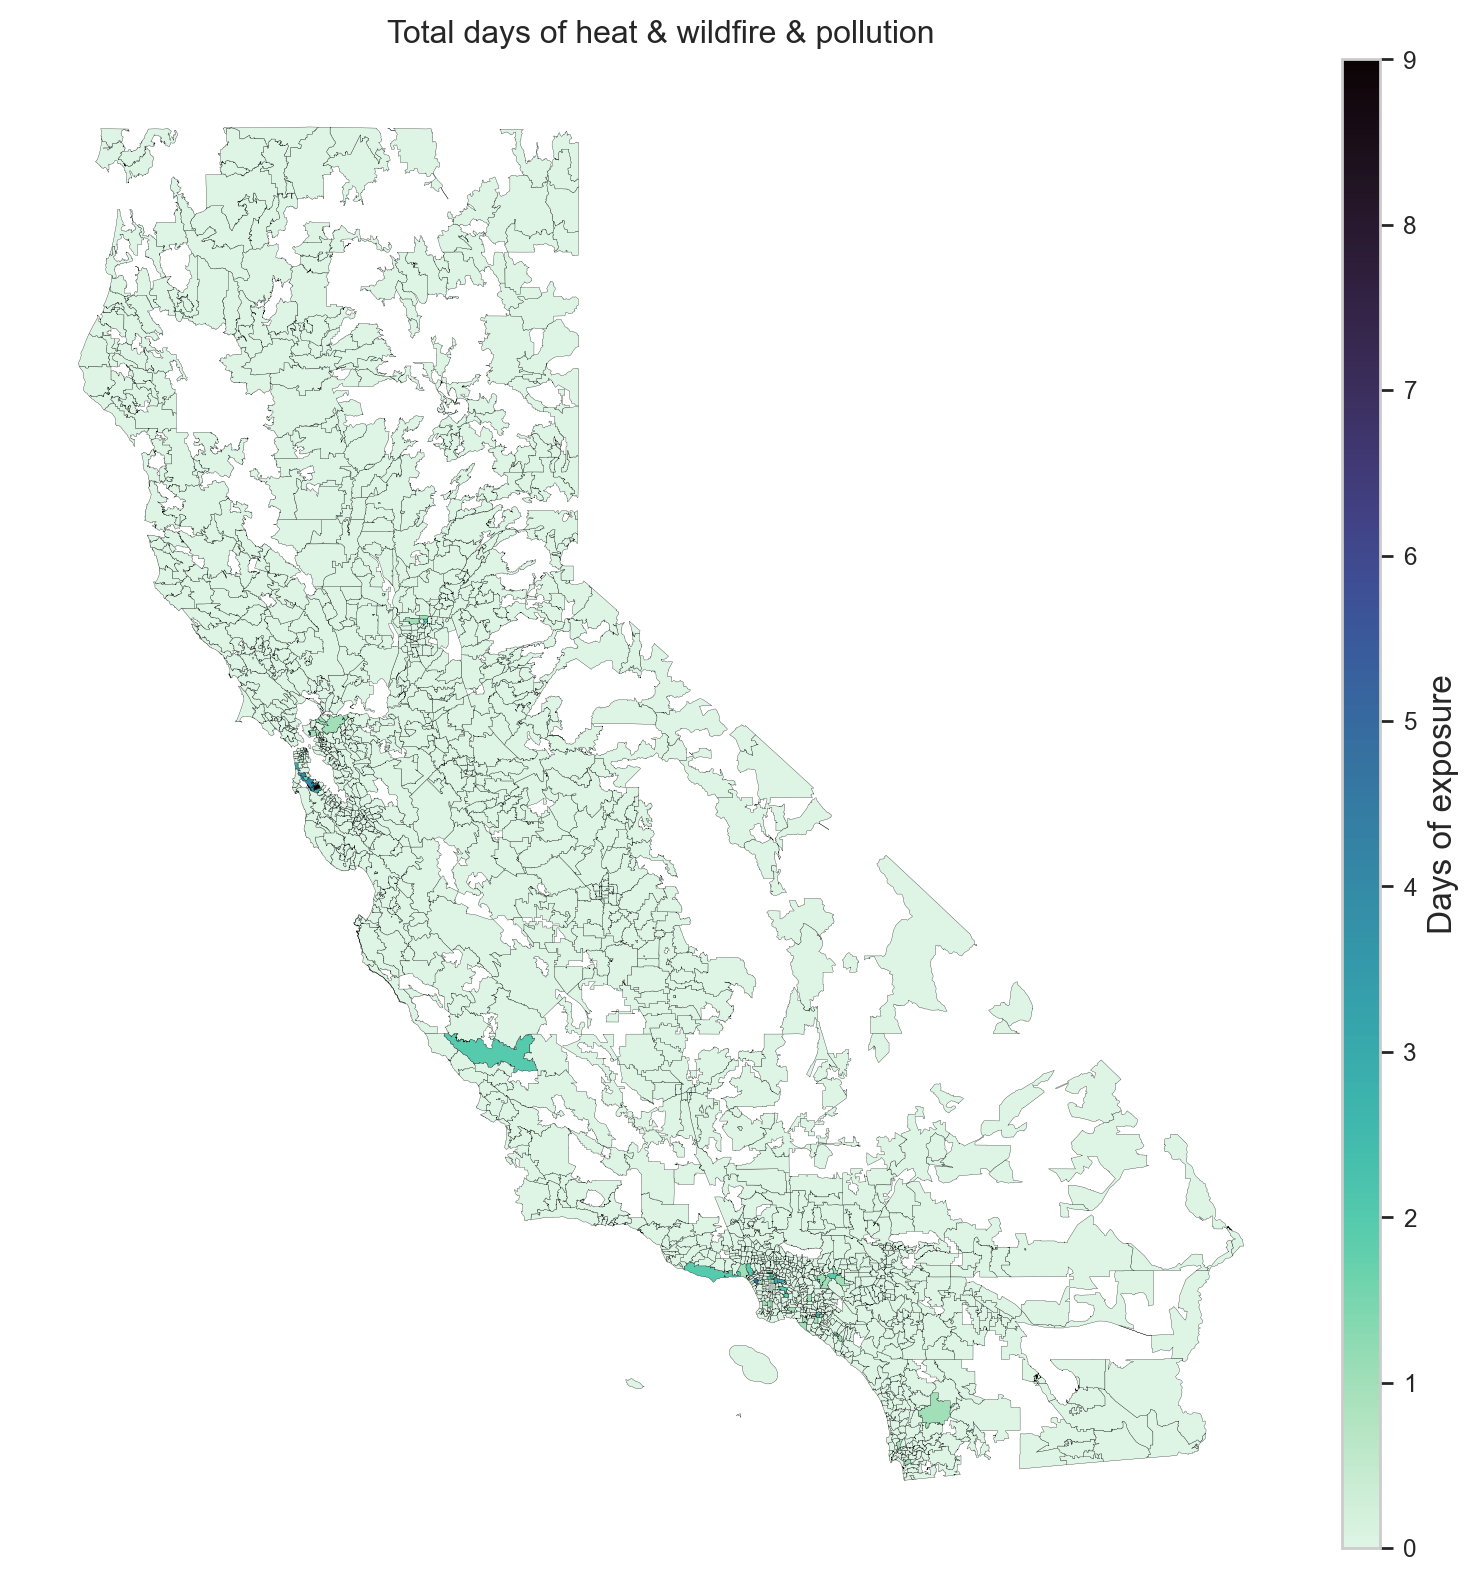

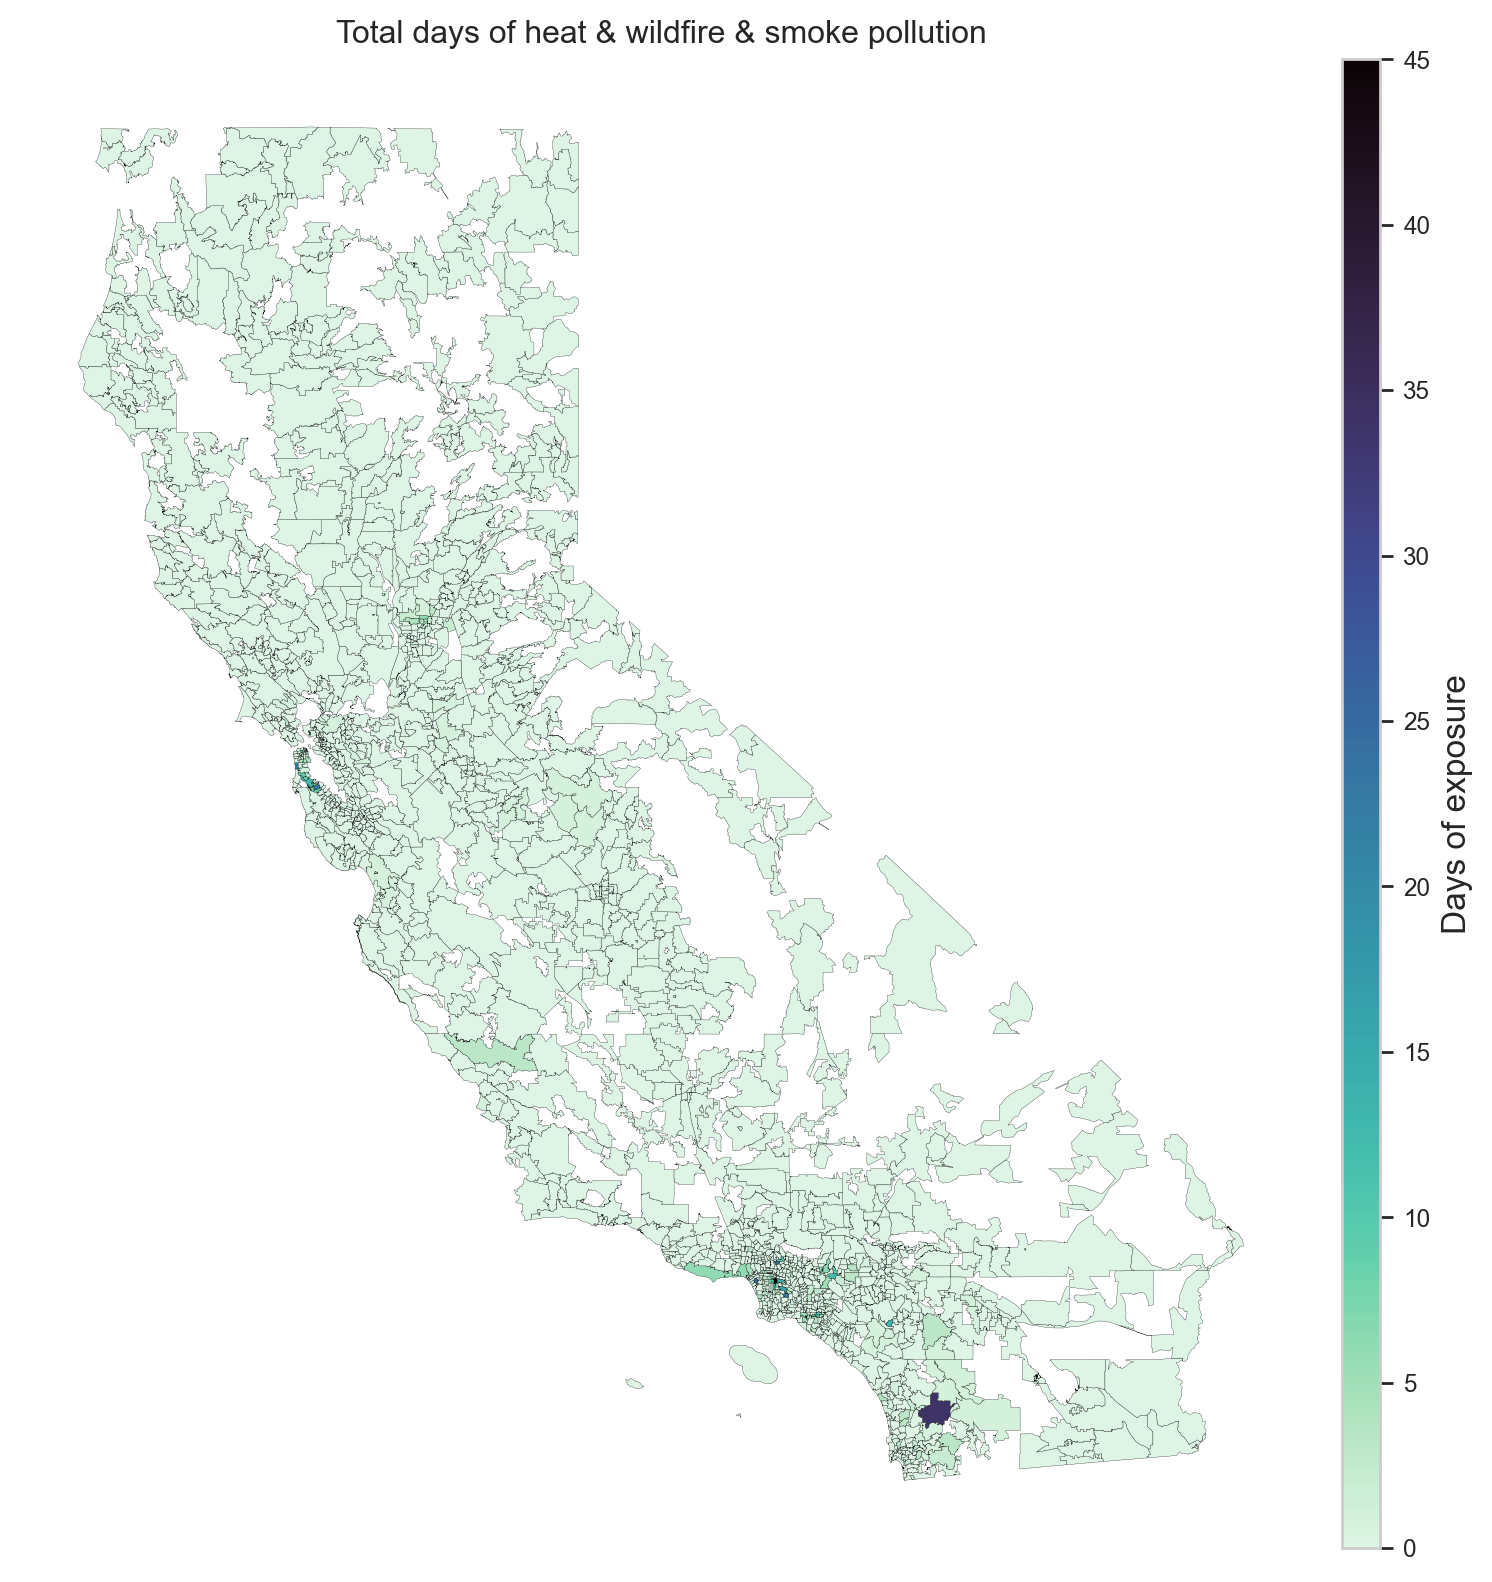

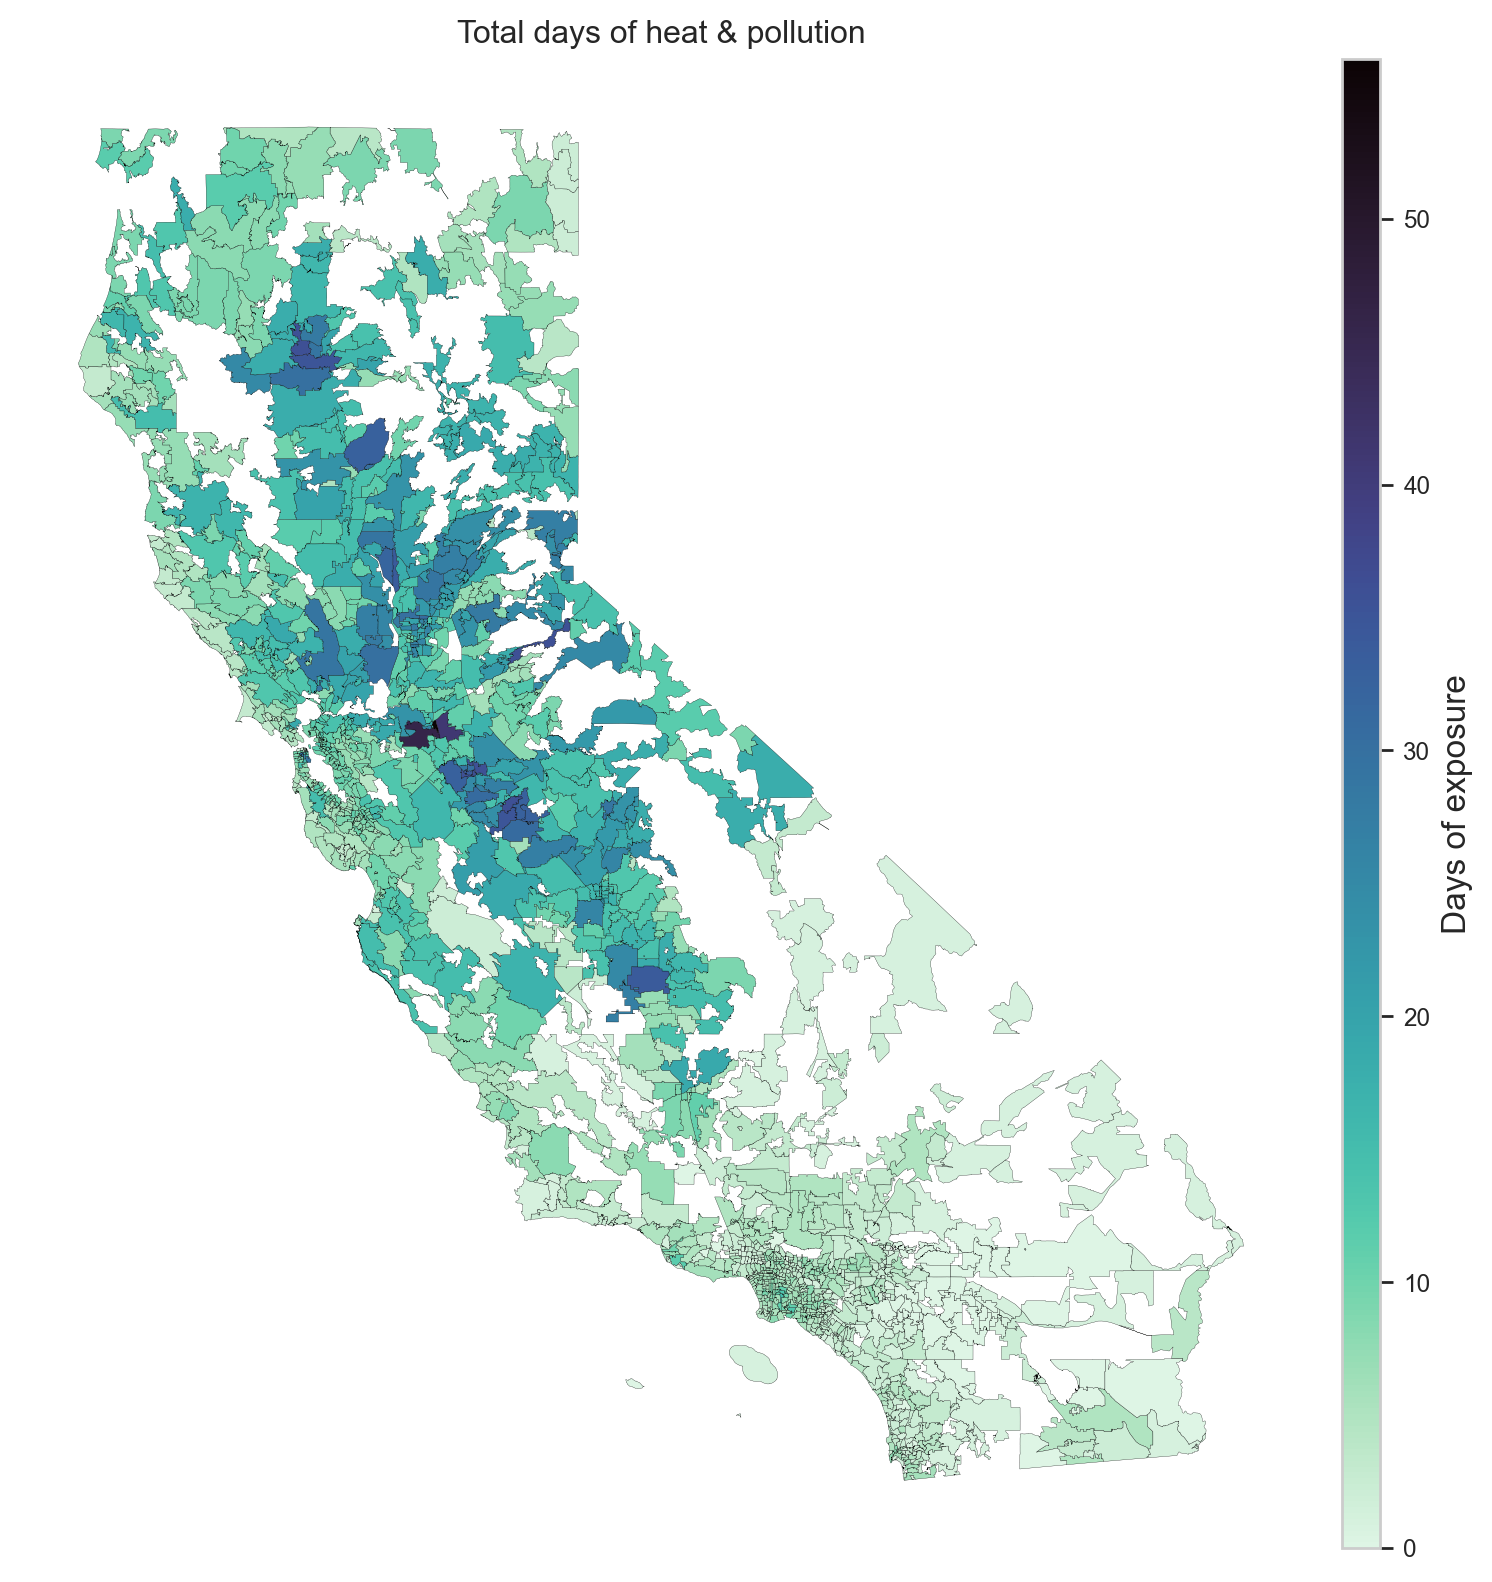

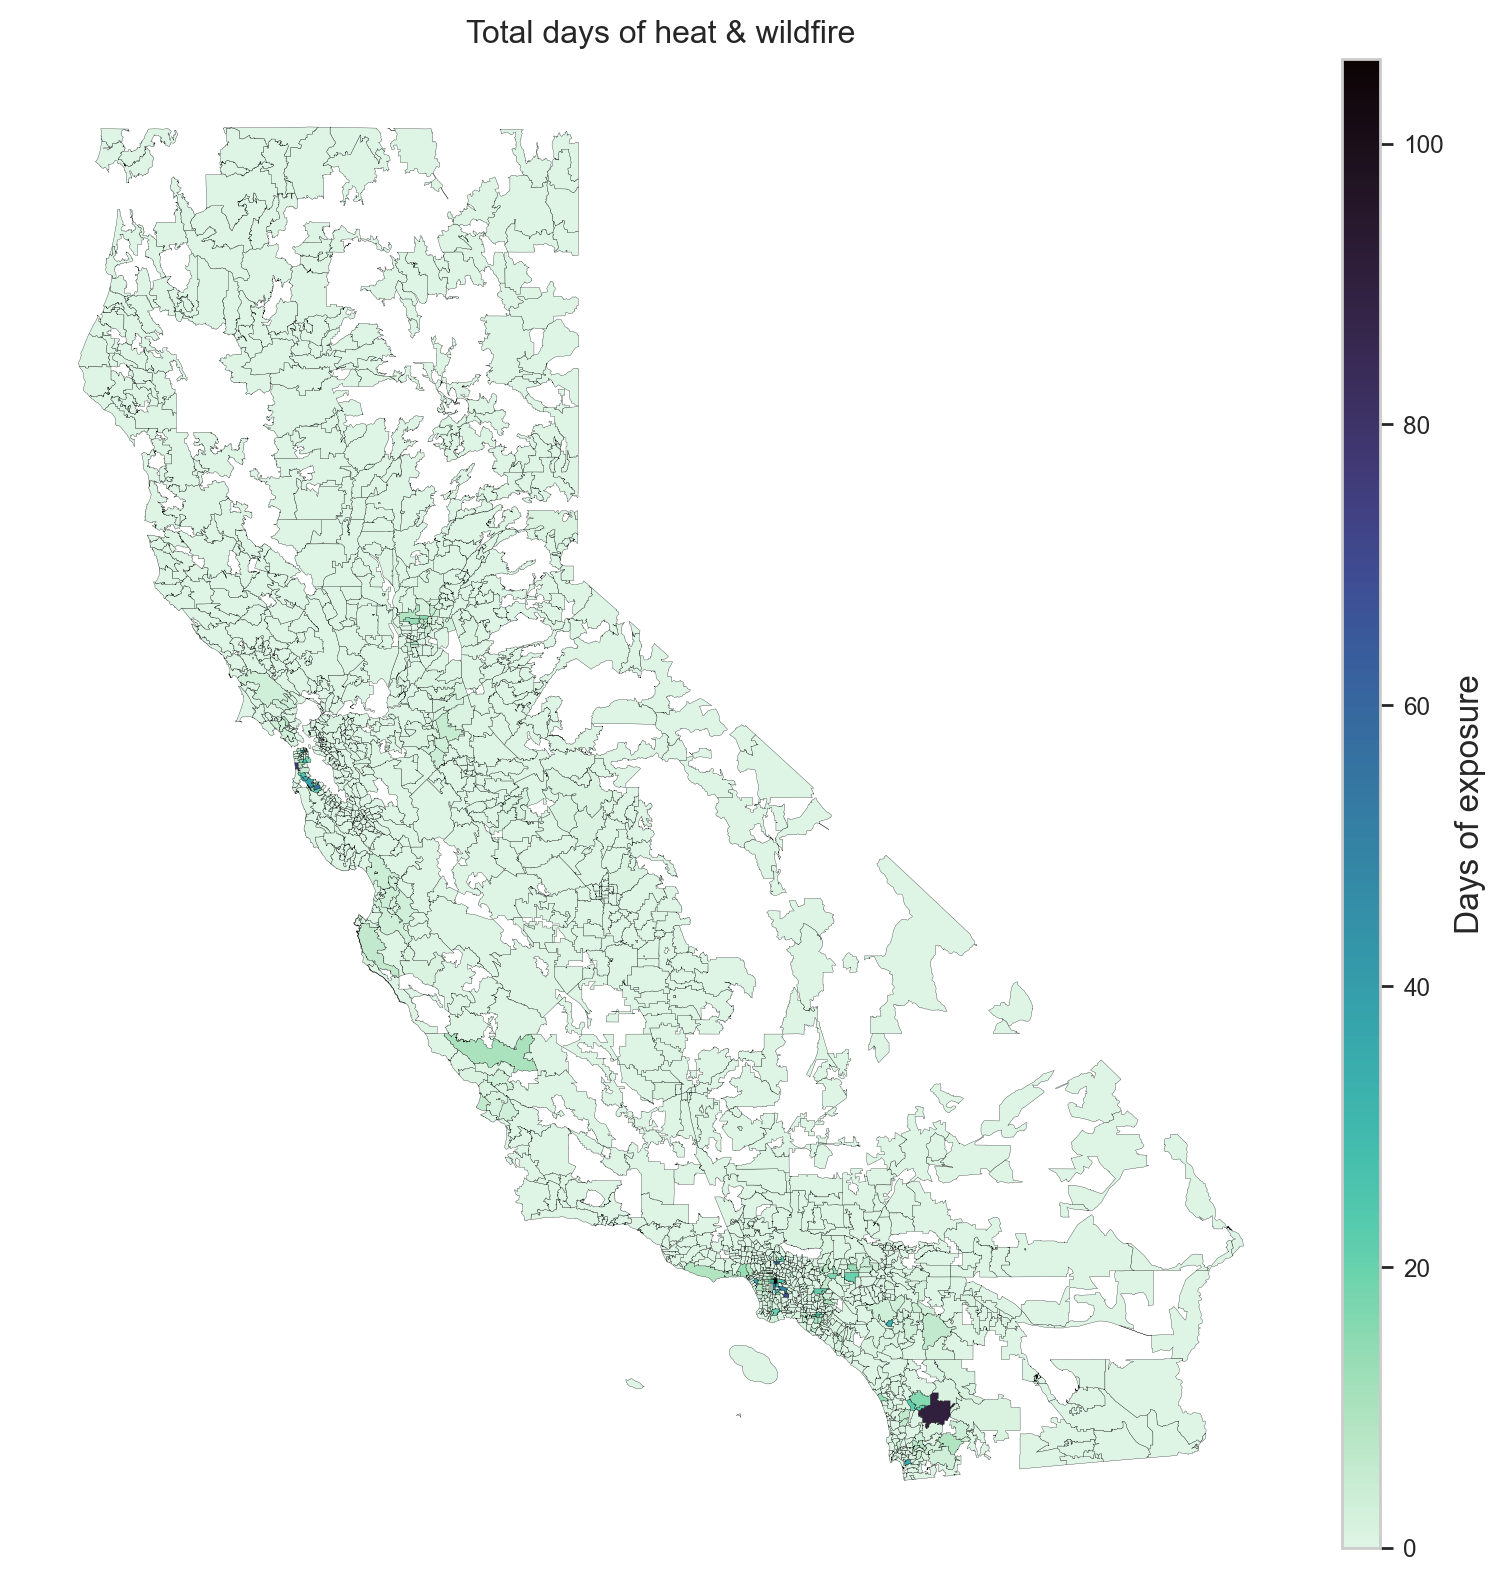

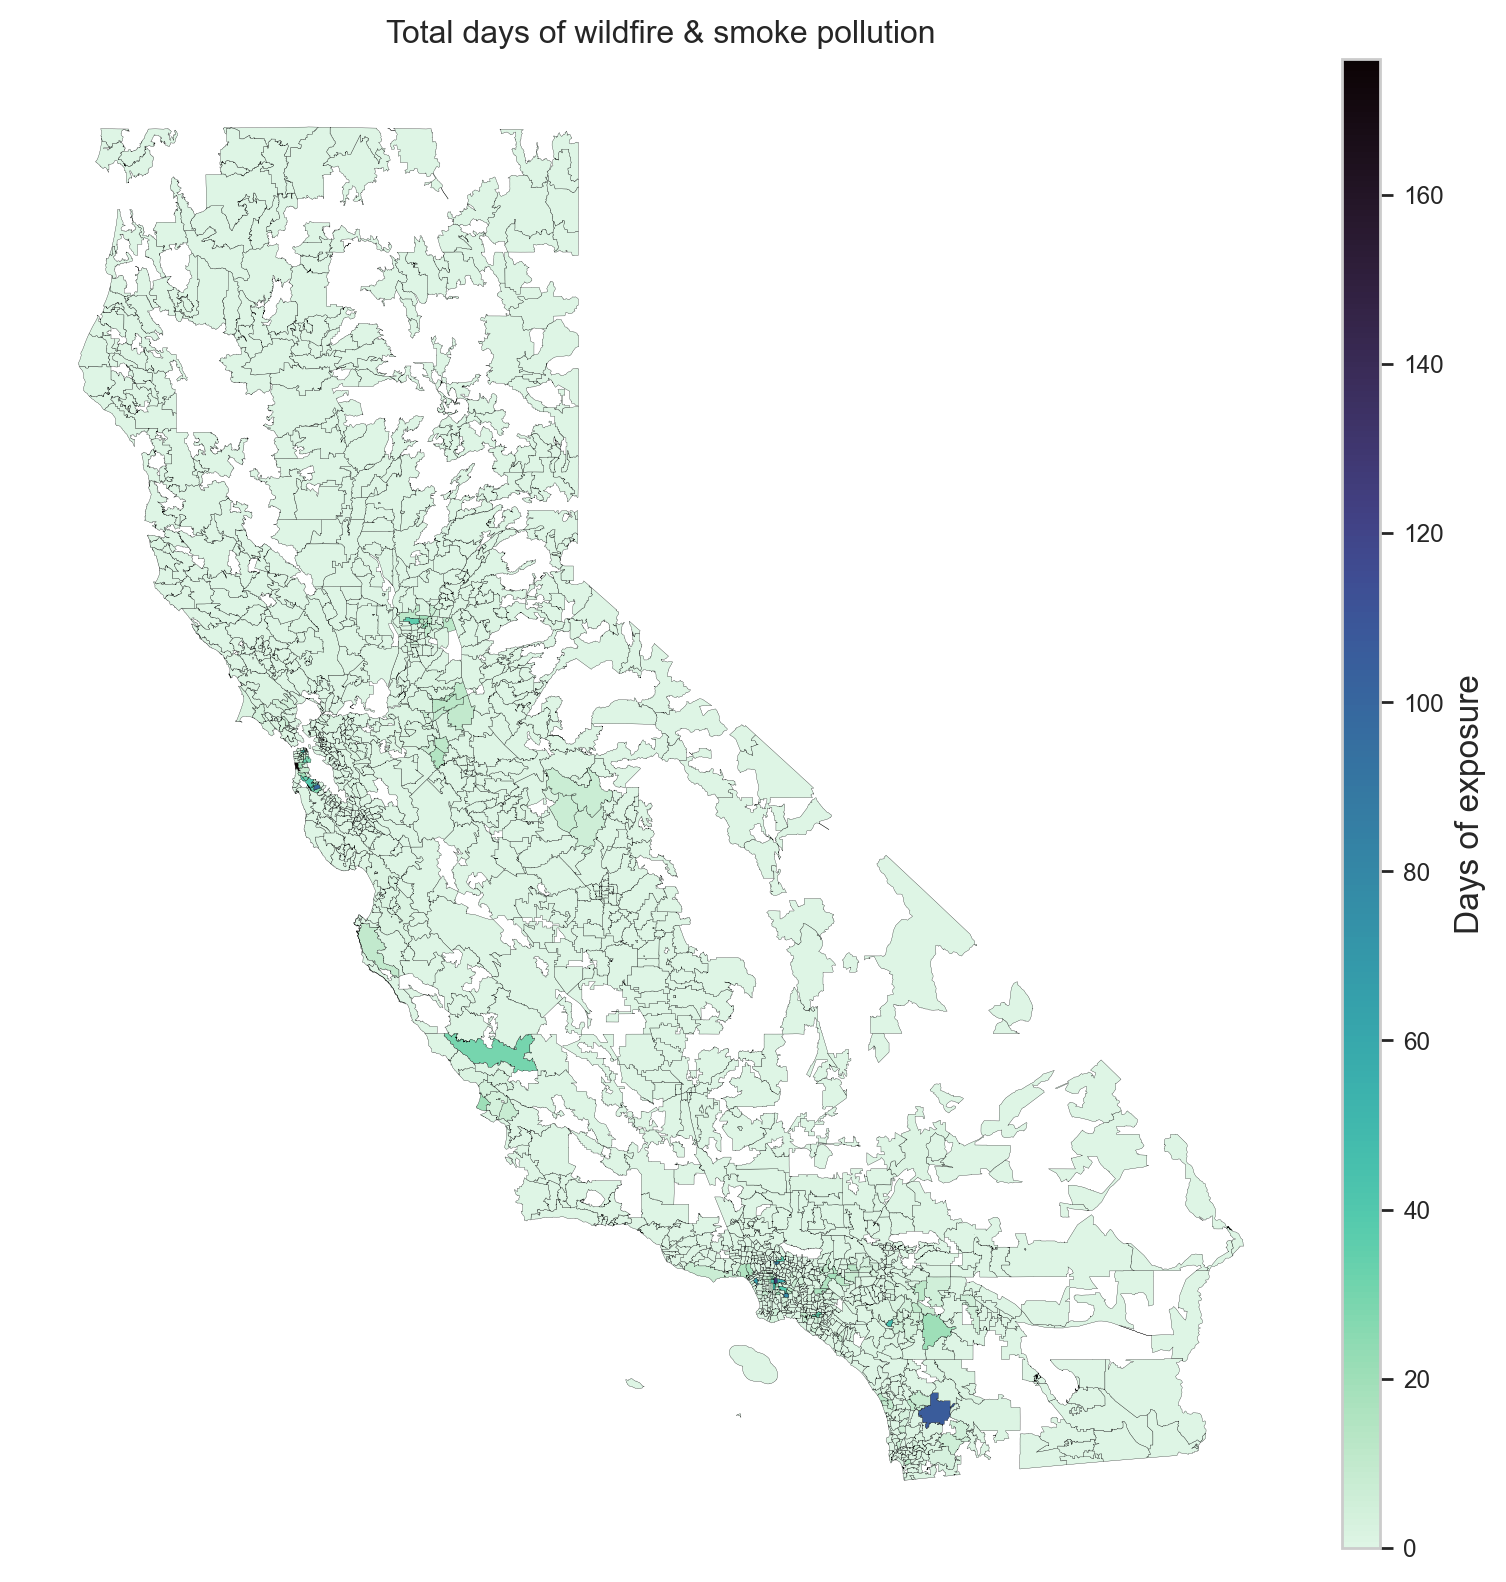

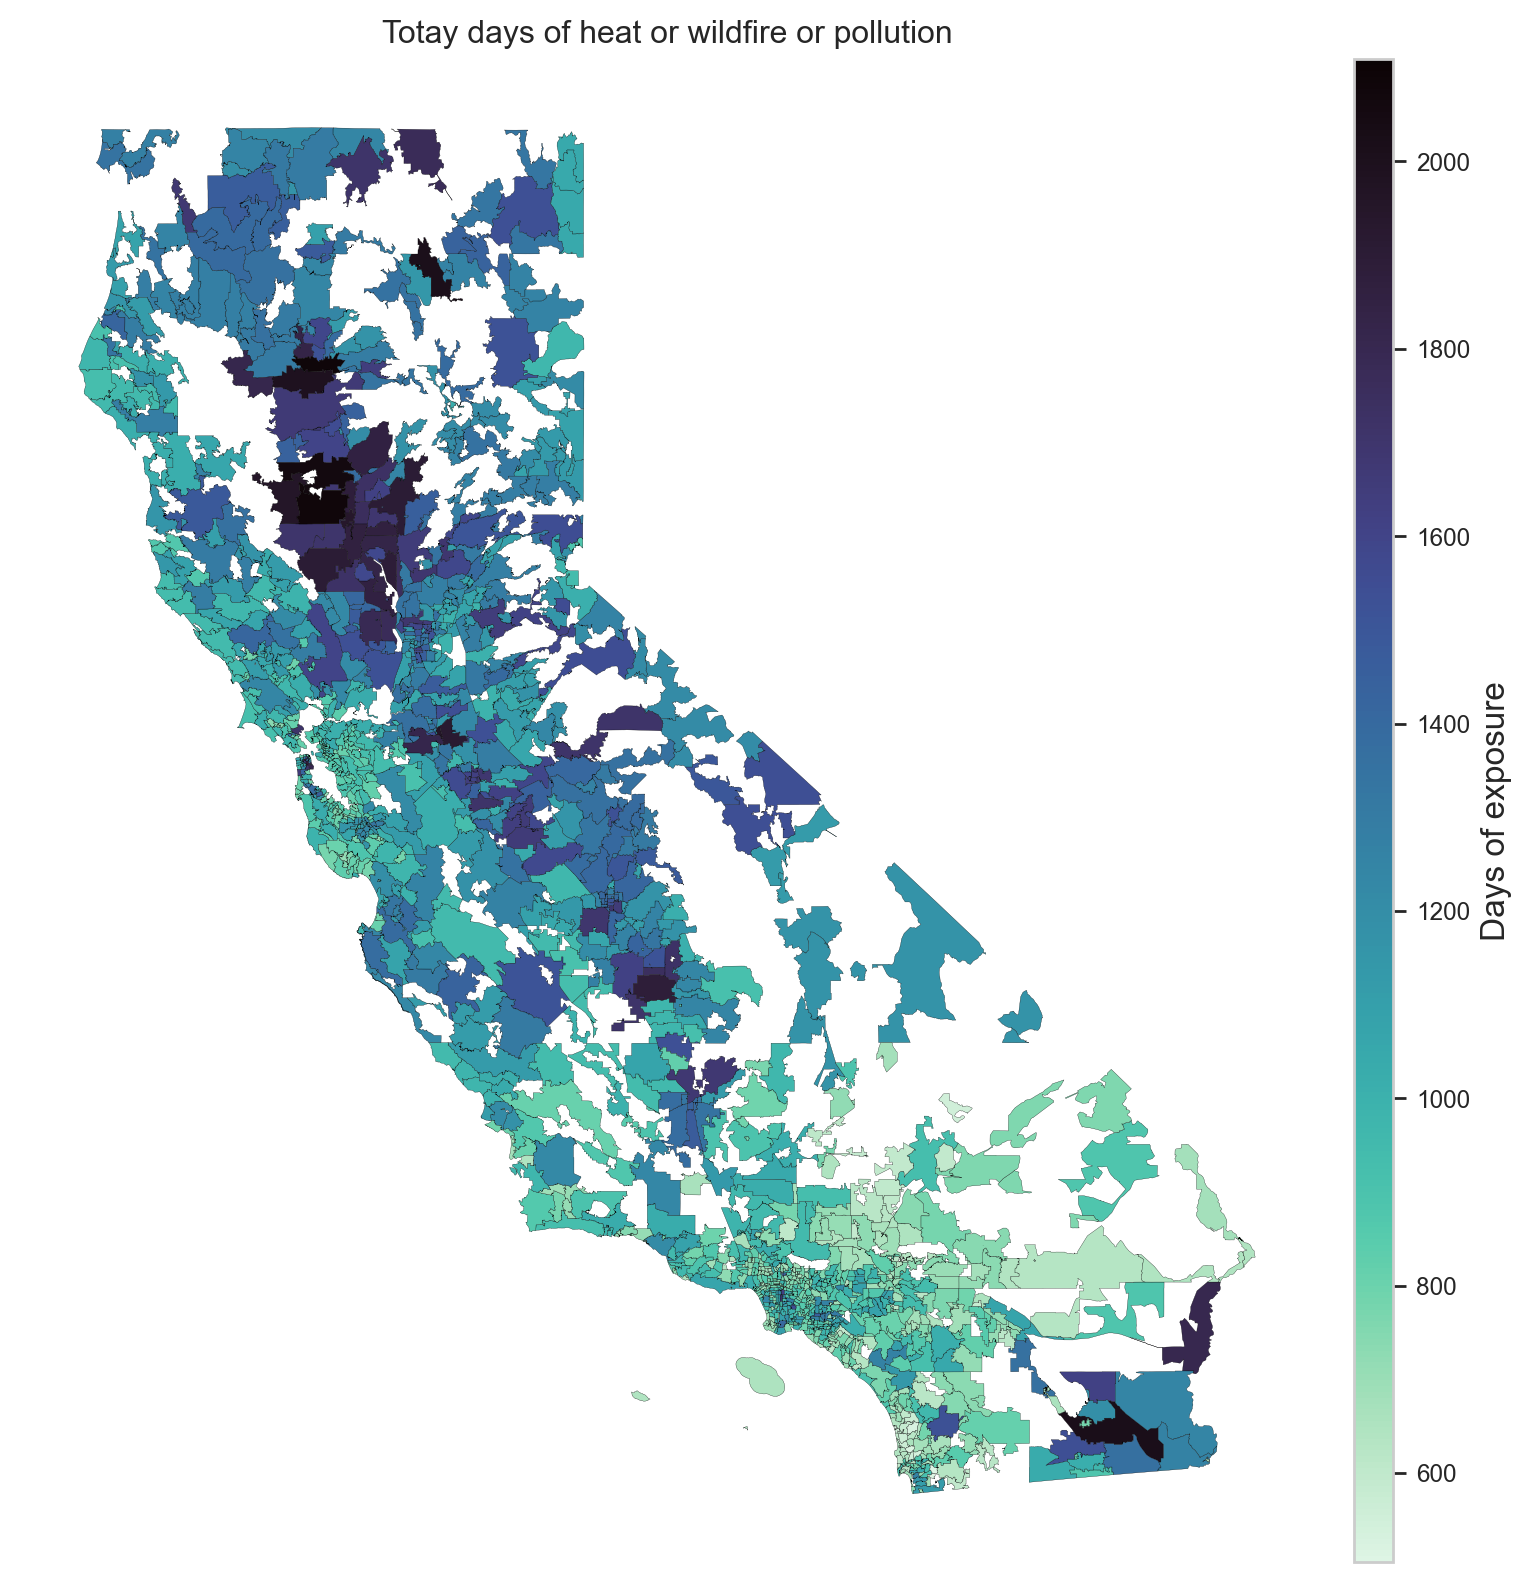

In [58]:
for hs in hss.keys():
    plotting.statePlot(df, hs, hss[hs]["title_map"],'mako_r',5,200)